In [1]:
import numpy as np
%matplotlib ipympl
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
from IPython.display import clear_output

In [2]:
import os
parent_dir = os.path.dirname(os.getcwd())
print(parent_dir)
os.chdir(parent_dir)
import mmars

c:\Users\rasmu\Documents\GitHub\MMARS


In [3]:
start_idx = 75
real_radar_data_file_01 = h5py.File(r"C:\Users\rasmu\Documents\GitHub\MMARS\mmars\realRadarFiles\RADARPC02____SU_STREIGHT_UP_R02_W_DRONE____02_Apr_2025_15_50_18_976942.mat")#,'r')
real_radar_data_01 = real_radar_data_file_01['IQreal'][:,0,:,:,:].T[:,:,:,np.newaxis,:] + 1.j*real_radar_data_file_01['IQimag'][:,0,:,:,:].T[:,:,:,np.newaxis,:]
real_radar_data_01 = real_radar_data_01[start_idx:]/(2**16)

background = np.loadtxt(r"C:\Users\rasmu\Documents\GitHub\MMARS\mmars\background\RADARPC02__Background_SU_TEST_mean_1024.txt", dtype=np.complex128)
background = background/(2**16)

background_time = np.loadtxt(r"C:\Users\rasmu\Documents\GitHub\MMARS\mmars\background\RADARPC02__Background_SU_TEST_mean_1024_time.txt", dtype=np.complex128)
background_time = background_time/(2**16)

In [4]:
real_radar_data_struct_01 = real_radar_data_file_01['dataStruct']
wavelength = 3e8/(real_radar_data_struct_01["StartFrequency"][0,0]*1e9)
real_radar_parameters_01 = { "position": np.array([[0,0]]),
                            "tx_antennas": np.array(([[0*(wavelength), 0], [2*(wavelength), 0] ])), 
                            "rx_antennas": np.array(([[(2+1.41+0/2)*(wavelength), 0], [(2+1.41+1/2)*(wavelength), 0], [(2+1.41+2/2)*(wavelength), 0], [(2+1.41+3/2)*(wavelength), 0]])), 
                            "chirp_Rate": real_radar_data_struct_01["SweepSlope"][0,0]*1e12, 
                            "N_samples": 128, 
                            "f_sampling": real_radar_data_struct_01["ADCSampleRate"][0,0]*1e3, 
                            "transmitPower": 6,
                            "gain": 10**(30/10),
                            "radarCrossSection": 1,
                            "standardDeviation": 4.44e-5,
                            "wavelength": wavelength,
                            "f_carrier": real_radar_data_struct_01["StartFrequency"][0,0]*1e9
                        }

In [5]:
radar_model_1 = mmars.FmcwRadar(position=real_radar_parameters_01["position"],
                            tx_antennas=real_radar_parameters_01["tx_antennas"],
                            rx_antennas=real_radar_parameters_01["rx_antennas"],
                            chirp_Rate=real_radar_parameters_01["chirp_Rate"],
                            N_samples=real_radar_parameters_01["N_samples"],
                            f_sampling=real_radar_parameters_01["f_sampling"],
                            transmitPower=real_radar_parameters_01["transmitPower"],
                            gain=real_radar_parameters_01["gain"],
                            radarCrossSection=real_radar_parameters_01["radarCrossSection"],
                            f_carrier=real_radar_parameters_01["f_carrier"],
                            N_chirps=1
                        )
# radar_model_2 = mmars.FmcwRadar(position=np.array([[0,0]]), signalNoiseRatio=[10, 10], N_chirps=1)
# radar_model_3 = mmars.FmcwRadar(position=np.array([[1.5,0]]), signalNoiseRatio=[10, 10], N_chirps=1)

## Setting up the target

In [6]:
T_frame = 0.1
real_target_model = mmars.RealTarget(r"C:\Users\rasmu\Documents\GitHub\MMARS\mmars\realTargetFiles\SU_STREIGHT_UP_R02_W_DRONE_REAL_TARGET.txt")
real_target_model.generate_trajectory()
real_target_ground_truth = real_target_model.get_trajectory()

5.999976000000002


C:\Users\rasmu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\rasmu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


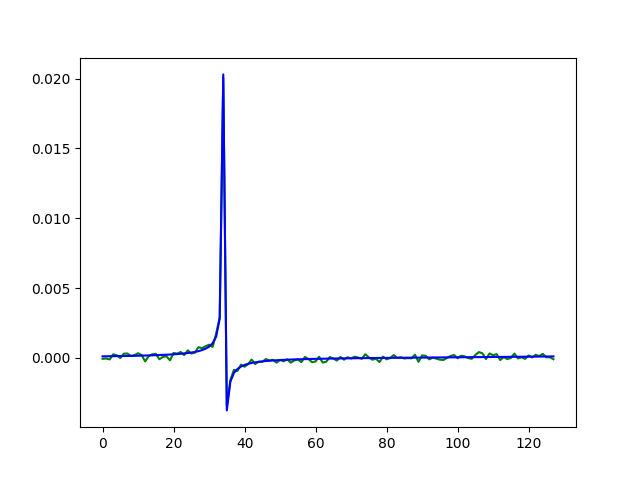

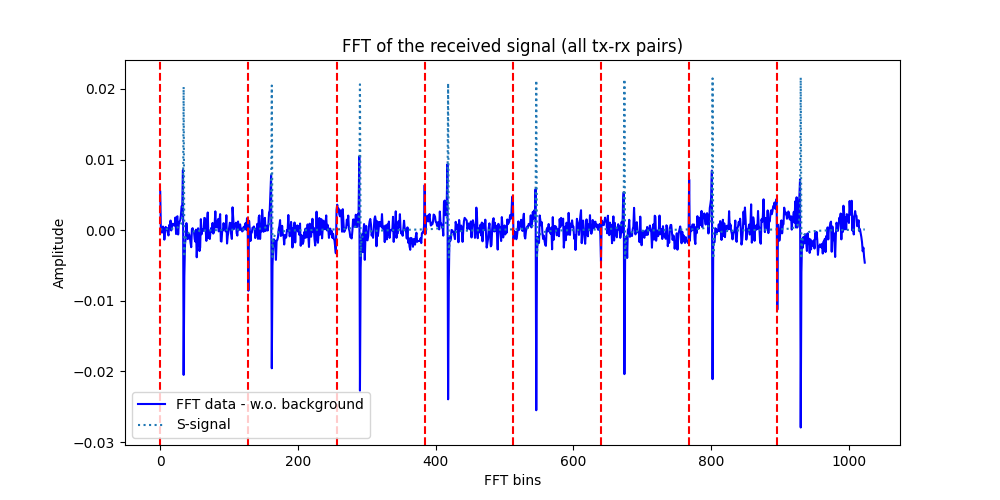

In [7]:
idx = 0
gt_idx_bias = 0

radar_model_1.radar_to_target_measures(target_x=real_target_ground_truth[0][idx+start_idx+gt_idx_bias],target_y=real_target_ground_truth[1][idx+start_idx+gt_idx_bias])
radar_model_1.generate_S_signal(target_x=real_target_ground_truth[0][idx+start_idx+gt_idx_bias],target_y=real_target_ground_truth[1][idx+start_idx+gt_idx_bias])
plt.figure()
plt.plot(np.fft.fft(radar_model_1.get_IF_signal[0,0,0,:]), label='FFT S-signal', color='g')
plt.plot(radar_model_1.get_S_signal[0,0,0,:], label='S-signal', color='b')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
data_fourier = np.fft.fft(real_radar_data_01[:,:,:,0,:],axis=-1)[:,:,:,np.newaxis,:]
ax.plot((np.real(data_fourier[idx].flatten()-background)), label='FFT data - w.o. background', color='b')
# ax.plot((np.real(data_fourier[idx].flatten())), label='FFT data', color='c', linestyle='--')

print(real_target_ground_truth[1][idx+start_idx+gt_idx_bias])
ax.plot(np.real(radar_model_1.get_S_signal.flatten()), label='S-signal', linestyle=':')
for radar_bin in np.linspace(0,1024,8,endpoint=False):
    ax.axvline(x=[radar_bin], color='r', linestyle='--')
ax.set_title("FFT of the received signal (all tx-rx pairs)")
ax.set_xlabel("FFT bins")
ax.set_ylabel("Amplitude")
plt.legend()


In [8]:
buffer_bins = 10
cheated_radar_data = np.zeros((real_radar_data_01.shape), dtype=np.complex128)
real_radar_data_fft_01 = np.fft.fft(real_radar_data_01, axis=-1)
for frame_idx in range(len(real_radar_data_fft_01)):
    real_radar_data_fft_01_temp = real_radar_data_fft_01
    real_radar_data_fft_01_temp[:,:,:,:,:20] = 0
    real_radar_data_fft_01_temp[:,:,:,:,-20:] = 0
    arg_max_bin = np.argmax(np.abs(real_radar_data_fft_01_temp[frame_idx,0,0,0]))
    cheated_radar_data[frame_idx,:,:,:,(arg_max_bin-buffer_bins//2):(arg_max_bin+(buffer_bins-buffer_bins//2))] = real_radar_data_fft_01[frame_idx,:,:,:,(arg_max_bin-buffer_bins//2):(arg_max_bin+(buffer_bins-buffer_bins//2))]

# plt.figure()
# plt.plot(np.real(cheated_radar_data[idx,:,:,:,:].flatten()))
# plt.show()

In [9]:
mrblatcomp = mmars.MRBLaT_Functions(radar_model_1.get_parameters)

gridsize = 100

x_values = np.linspace(-15.736, 15.736, gridsize)  # 0 to 50 (inclusive)
y_values = np.linspace(3, 15.736, gridsize)
# x_values = np.linspace(-1, 1, gridsize)  # 0 to 50 (inclusive)
# y_values = np.linspace(5, 7, gridsize)

X, Y = np.meshgrid(x_values, y_values)

# Flatten the grid and stack with phi[2] = 0, phi[3] = 0
phis = [np.array([[x], [y], [1],  [1]]) for x, y in zip(X.ravel(), Y.ravel())]

# Convert to NumPy array (shape: (2500, 4, 1))
phis = np.array(phis)

print(f"Shape of phis: {phis.shape}")  # Expected: (2500, 4, 1)
#print(phis[:-2])  # Print first few vectors

result = []
print(data_fourier.shape)  # Expected: (128,)
for i in tqdm(range(len(phis))):
    result.append(mrblatcomp.D_KL(phis[i,:,0], (data_fourier[idx]).flatten(), 0, 10, (1,1,1,1), False))

Shape of phis: (10000, 4, 1)
(351, 2, 4, 1, 128)


100%|██████████| 10000/10000 [00:25<00:00, 390.64it/s]


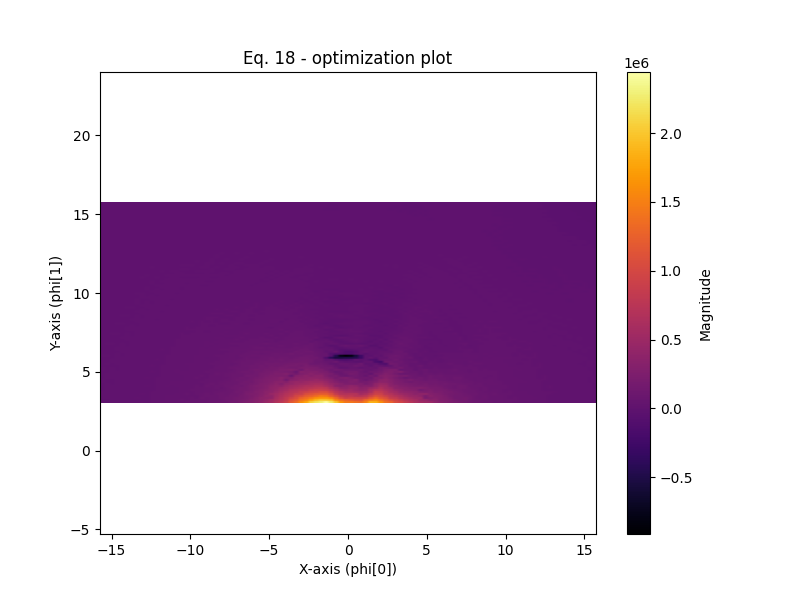

Minimum value at index: (np.int64(23), np.int64(49))
x: -0.15894949494949628, y: 5.958868686868687


In [10]:
# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(result).reshape(gridsize, gridsize)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(((heatmap[:,:])), origin='lower', extent=[-15.736, 15.736, 3, 15.736], cmap='inferno')#, aspect='auto')
# plt.imshow(((heatmap[:,:])), origin='lower', extent=[-1, 1, 5, 7], cmap='inferno')#, aspect='auto')
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("Eq. 18 - optimization plot")
plt.axis('equal')
plt.show()

min_index = np.argmin((heatmap))
min_index_2d = np.unravel_index(min_index, heatmap.shape)
x_min = x_values[min_index_2d[1]]
y_min = y_values[min_index_2d[0]]

print(f"Minimum value at index: {min_index_2d}")
print(f"x: {x_min}, y: {y_min}")


# DKL DILLER

In [11]:
# from scipy.optimize import minimize
# x0 = (0,5.1,0.1,0.1)
# res = []
# for frame in tqdm(cheated_radar_data):
#     DKL_res = minimize(mrblatcomp.D_KL, x0, args=(frame.flatten(), x0[0], x0[1], (1,1,1,1), False), method='nelder-mead', bounds=[(-10, 10), (3, 20), (0.01, 10), (0.01, 10)])
#     x0 = DKL_res.x
#     res.append(x0)

In [12]:
# res = np.array(res)
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.plot(res[:25,0], res[:25,1], 'ro')
# ax.plot(res[25:50,0], res[25:50,1], 'bo')
# ax.set_xlim(-2, 2)

# MRBLaT

In [13]:
print(real_radar_data_01.shape)
intial_guess = np.array([[real_target_ground_truth[0][start_idx+gt_idx_bias]], [real_target_ground_truth[1][start_idx+gt_idx_bias]], [real_target_ground_truth[2][start_idx+gt_idx_bias]], [real_target_ground_truth[3][start_idx+gt_idx_bias]]])
intial_guess = np.array([[0], [6], [0], [0]])
real_single_radar = mmars.Tracking([real_radar_data_01 - np.reshape(background_time,(real_radar_data_01[0].shape))], [real_radar_parameters_01], intial_guess)

(351, 2, 4, 1, 128)


In [14]:
real_single_phi_bar, real_single_phi_barbar = real_single_radar.run_mrblat(T_frame, fifo_length=25, N_frames=50, N_iter=500)

  4%|▍         | 2/50 [00:01<00:31,  1.51it/s]c:\Users\rasmu\Documents\GitHub\MMARS\mmars\tracking.py:83: OptimizeWarning: Initial guess is not within the specified bounds
  D_KL_result = minimize(mrblat_functions_list[k].D_KL, x0, bounds = bound,  args=(data_fourier, x0[0], x0[1], (1,1,1,1), False), method='nelder-mead')
100%|██████████| 50/50 [01:12<00:00,  1.45s/it]


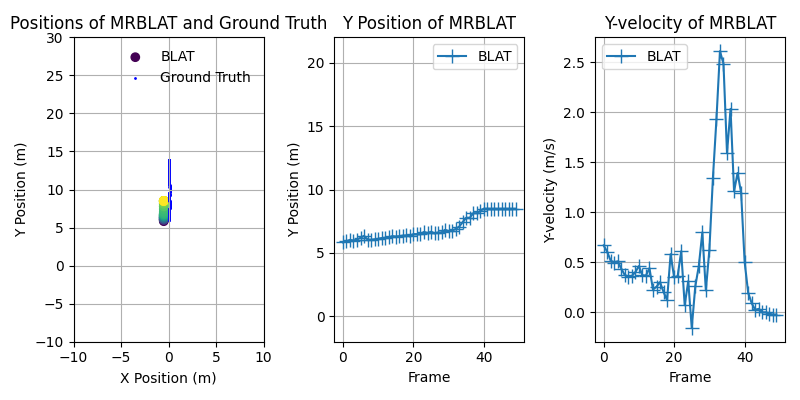

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(8, 4))
ax[0].scatter(real_single_phi_bar[:,0], real_single_phi_bar[:,1], label="BLAT", cmap="viridis", c=np.linspace(0,1,len(real_single_phi_bar)))
ax[0].scatter(real_target_ground_truth[0][start_idx:], real_target_ground_truth[1][start_idx:], label="Ground Truth", color="blue",s=1)
ax[0].set_title("Positions of MRBLAT and Ground Truth")
ax[0].set_xlabel("X Position (m)")
ax[0].set_ylabel("Y Position (m)")
ax[0].legend(framealpha=0.)
ax[0].grid(True)
ax[0].set_ylim(-10, 30)
ax[0].set_xlim(-10, 10)

ax[1].plot(real_single_phi_bar[:,1], label="BLAT", marker="+", markersize=10)
# ax[1].plot(multi_phi_bar[:,1], label="MRBLAT", marker="+", markersize=10)
ax[1].set_xlabel("Frame")
ax[1].set_ylabel("Y Position (m)")
ax[1].set_title("Y Position of MRBLAT")
ax[1].legend()
ax[1].grid(True)
ax[1].set_ylim(-2, 22)

ax[2].plot(real_single_phi_bar[:,3], label="BLAT", marker="+", markersize=10)
# ax[2].plot(multi_phi_bar[:,3], label="MRBLAT", marker="+", markersize=10)
ax[2].set_xlabel("Frame")
ax[2].set_ylabel("Y-velocity (m/s)")
ax[2].set_title("Y-velocity of MRBLAT")
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()
plt.show()

In [16]:
print(real_single_phi_barbar)

[[[ 6.94751993e-06  0.00000000e+00 -3.95577840e-05  0.00000000e+00]
  [ 0.00000000e+00  9.99041640e-06  0.00000000e+00 -2.25552146e-05]
  [-3.95577840e-05  0.00000000e+00  7.83284435e-04  0.00000000e+00]
  [ 0.00000000e+00 -2.25552146e-05  0.00000000e+00  1.82267991e-01]]

 [[ 3.73906389e-06  0.00000000e+00 -1.48456298e-05  0.00000000e+00]
  [ 0.00000000e+00  1.02384231e-05  0.00000000e+00 -8.10710961e-06]
  [-1.48456298e-05  0.00000000e+00  4.39029113e-04  0.00000000e+00]
  [ 0.00000000e+00 -8.10710961e-06  0.00000000e+00  7.22732362e-02]]

 [[ 3.75054767e-06  0.00000000e+00 -1.48919315e-05  0.00000000e+00]
  [ 0.00000000e+00  1.02980841e-05  0.00000000e+00 -3.19753445e-06]
  [-1.48919315e-05  0.00000000e+00  4.39185549e-04  0.00000000e+00]
  [ 0.00000000e+00 -3.19753445e-06  0.00000000e+00  3.01459475e-02]]

 [[ 3.74155184e-06  0.00000000e+00 -1.48563899e-05  0.00000000e+00]
  [ 0.00000000e+00  1.01523103e-05  0.00000000e+00 -3.98562941e-06]
  [-1.48563899e-05  0.00000000e+00  4.3903

100%|██████████| 351/351 [00:00<00:00, 597.00it/s]


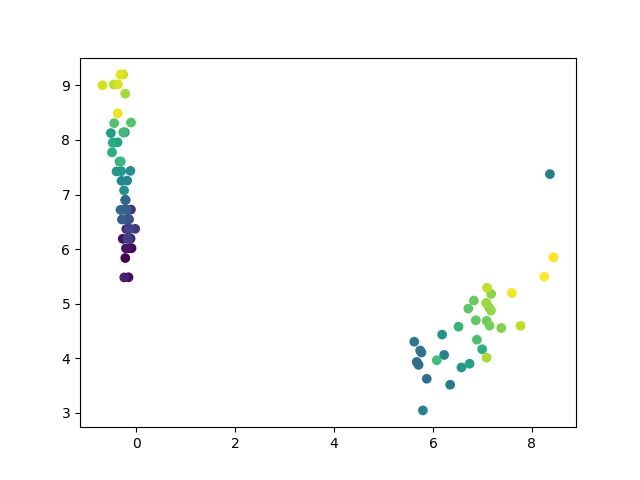

: 

In [ ]:
def doa_music(R, n_sig, d = 0.5, scan_angles = range(-90, 91)):
    """ MUSIC algorithm implementation """
    n_array = np.shape(R)[0]
    array = np.linspace(0, (n_array - 1) * d, n_array)
    scan_angles = np.array(scan_angles)

    # 'eigh' guarantees the eigen values are sorted
    _, e_vecs = np.linalg.eigh(R)
    noise_subspace = e_vecs[:, :-n_sig]

    array_grid, angle_grid = np.meshgrid(array, np.radians(scan_angles), indexing = "ij")
    steering_vec = np.exp(-1.j * 2 * np.pi * array_grid * np.sin(angle_grid)) 
    
    # 2-norm (frobenius)
    ps = 1 / np.square(np.linalg.norm(steering_vec.conj().T @ noise_subspace, axis = 1))

    return 10 * np.log10(ps)

def run_tracking(frames):
    tracking_data_x = np.zeros(len(frames))
    tracking_data_y = np.zeros(len(frames))
    tracking_data_vx = np.zeros(len(frames))
    tracking_data_vy = np.zeros(len(frames))

    max_range = 22.48
    N_samples = 128
    range_values = np.linspace(0, max_range, N_samples,)

    k = 0       

    for frame in tqdm(frames):
        # range_fft = np.fft.fft(frame, axis=-1)
        # range_fft = np.abs(range_fft)
        # range_fft[:,:,0,:20] = 0
        # range_fft[:,:,0,-20:] = 0
        radial_distance = range_values[np.argmax(frame[0,0,0])]
        # print(radial_distance)
        # arg_max_idx = np.argmax(range_fft[0,0,0,:])

        # idx = radar_setup.get_IF_signal.shape
        phasors = np.zeros((8, 128), dtype=complex)
        for i in range(2):
            for j in range(4):
                phasors[i*(2+1)+j] = frame[i,j,0]#range_fft[i,j,0,arg_max_idx-3:arg_max_idx+3]
        
        # clear_output(wait=True)
        # fig, ax = plt.subplots(1,1,figsize=(8, 4))
        # ax.plot(range_fft[0,0,0])
        # ax.axvline(x=arg_max_idx, color='r', linestyle='--')
        # ax.axvline(x=arg_max_idx-3, color='r', linestyle='--')
        # ax.axvline(x=arg_max_idx+3, color='r', linestyle='--')
        # plt.show()
        # plt.pause(0.1)

        R = phasors @ phasors.conj().T*(1/N_samples)
        ### MUSIC
        music = doa_music(R, 1, scan_angles = np.linspace(-90, 90, 1001))
        anglebins = np.linspace(-90, 90, 1001)

        # clear_output(wait=True)
        # fig, ax = plt.subplots(1,1,figsize=(8, 4))
        # ax.plot(anglebins,music)
        # ax.axvline(x=anglebins[np.argmax(music)], color='r', linestyle='--')
        # plt.show()
        # plt.pause(.5)
        

        detected_angle = anglebins[np.argmax(music)]

        tracking_data_x[k] = radial_distance*np.cos(np.deg2rad(90-detected_angle))
        tracking_data_y[k] = radial_distance*np.sin(np.deg2rad(90-detected_angle))
        # print(tracking_data_y[k])
        tracking_data_vx[k] = 0
        tracking_data_vy[k] = 0

        k = k+1
        
    return tracking_data_x, tracking_data_y
# print(data_fourier.shape)

from scipy.signal.windows import hann
window = hann(real_radar_data_01.shape[-1])
windowed_signal = real_radar_data_01 * window

tracking_data_x, tracking_data_y = run_tracking(cheated_radar_data)
plt.figure()
plt.scatter(tracking_data_x[:90], tracking_data_y[:90], c=np.linspace(0,1,90), cmap="viridis")

In [ ]:
simulated_radar_model_1 = radar_model_1 # mmars.FmcwRadar(np.array([[0,0]]), N_chirps=1) # 
target_model = mmars.SimulatedTarget(start_position=np.array([[0.,5.]]), start_velocity=1., T_total=100., T_frame=T_frame)
target_model.generate_trajectory(trajectory_type="linear")
target_ground_truth = target_model.get_trajectory()
simulation_data_1 = mmars.Simulation(simulated_radar_model_1, target_model)
simulation_data_1.run()
sim_data_1 = simulation_data_1.get_data()
intial_guess = np.array([[0], [5], [0], [0]])
# print(sim_data_1[0])
simulated_single_radar = mmars.Tracking([sim_data_1], [simulated_radar_model_1.get_parameters], intial_guess)
sim_single_phi_bar,sim_single_phi_barbar = simulated_single_radar.run_mrblat(T_frame, fifo_length=25, N_frames=500, N_iter=500)

Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x000001F973F361D0> and <mmars.target__simulatedTarget.SimulatedTarget object at 0x000001F97C65F650>


  1%|▏         | 7/500 [00:05<07:29,  1.10it/s]

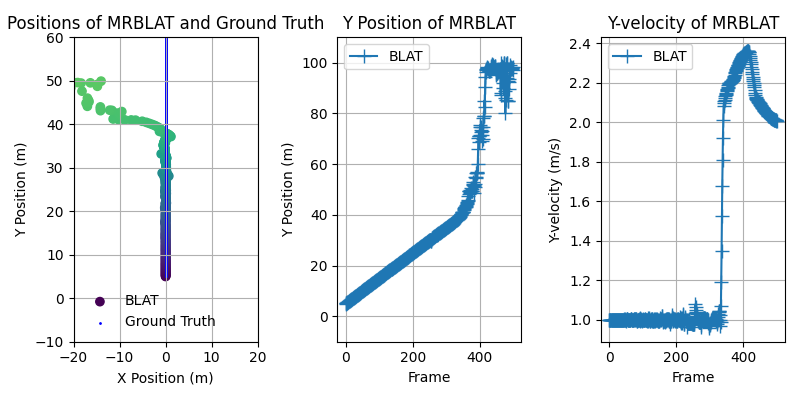

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 4))
ax[0].scatter(sim_single_phi_bar[:,0], sim_single_phi_bar[:,1], label="BLAT", cmap="viridis", c=np.linspace(0,1,len(sim_single_phi_bar)))
ax[0].scatter(target_ground_truth[0], target_ground_truth[1], label="Ground Truth", color="blue",s=1)
ax[0].set_title("Positions of MRBLAT and Ground Truth")
ax[0].set_xlabel("X Position (m)")
ax[0].set_ylabel("Y Position (m)")
ax[0].legend(framealpha=0.)
ax[0].grid(True)
ax[0].set_ylim(-10, 60)
ax[0].set_xlim(-20, 20)

ax[1].plot(sim_single_phi_bar[:,1], label="BLAT", marker="+", markersize=10)
# ax[1].plot(multi_phi_bar[:,1], label="MRBLAT", marker="+", markersize=10)
ax[1].set_xlabel("Frame")
ax[1].set_ylabel("Y Position (m)")
ax[1].set_title("Y Position of MRBLAT")
ax[1].legend()
ax[1].grid(True)
ax[1].set_ylim(-10, 110)

ax[2].plot(sim_single_phi_bar[:,3], label="BLAT", marker="+", markersize=10)
# ax[2].plot(multi_phi_bar[:,3], label="MRBLAT", marker="+", markersize=10)
ax[2].set_xlabel("Frame")
ax[2].set_ylabel("Y-velocity (m/s)")
ax[2].set_title("Y-velocity of MRBLAT")
ax[2].legend()
ax[2].grid(True)
plt.tight_layout()
plt.show()
